# Result Analysis for W266 Final Project

Import the packages used

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import result_analysis_utils as rau

Set common variables used in the analysis

In [2]:
map_dict = {'positive':0, 'neutral':1, 'negative':2, 'conflict':3, 'none':4}

## 1 Tuning
In this section, we evaluate different models' performances on the dev set in order to selection the best performing model and evaluate on the test set.

In [3]:
train_file = "../../data/semeval2016/bert-pair/text-level/EN_Laptop_Text_Train_NLI_M.csv"
dev_file = "../../data/semeval2016/bert-pair/text-level/EN_Laptop_Text_Dev_NLI_M.csv"

# load data for training
df_train = pd.read_csv(train_file, 
                       delimiter = "\t",
                       names = ["sent_id", "label", "entity:aspect", "text"]
                       )
df_train["label"] = df_train.label.map(map_dict)

# load data for tuning
df_dev = pd.read_csv(dev_file, 
                       delimiter = "\t",
                       names = ["sent_id", "label", "entity:aspect", "text"]
                       )
df_dev["label"] = df_dev.label.map(map_dict)

In [4]:
result_dirs = {
    #First Iteration
    "./text-level/XLIN_NLI_M_512/":("Basic", df_dev),
    
    #Second Iteration
    "./text-level/XLIN_NLI_M_512_Combo_2_05/":("Combo-Sampling-1", df_dev),
    "./text-level/XLIN_NLI_M_512_Combo_3_045/":("Combo-Sampling-2", df_dev),
    "./text-level/XLIN_NLI_M_512_Combo_5_04/":("Combo-Sampling-3", df_dev),
    
    #Third Iteration
    "./text-level/XLIN_NLI_M_512_Over_2/":("Over-Sampling-1", df_dev),
    "./text-level/XLIN_NLI_M_512_Over_Mix_1/":("Over-Sampling-2", df_dev),
    
    }

In [5]:
df = rau.combine_labels_preds(result_dirs)

### Generate the figures in table 1

In [6]:
# distribution of examples by label
count_by_label = df_train.groupby(by="label").sent_id.count()
display = (count_by_label/count_by_label.sum()).to_frame()
display.columns = ["proportion"]
display["label"] = ['positive', 'neutral', 'negative', 'conflict', 'none']
display.set_index("label")

,proportion
label,
positive,0.014688
neutral,0.001672
negative,0.009074
conflict,0.000513
none,0.974052


### 1.1 Calculate the metrics for aspect category detection and sentiment detection subtasks

In [7]:
metrics_df = rau.generate_confusion_matrix(df)

In [8]:
overall_metrics_df = metrics_df.reset_index() \
                               .fillna(0) \
                               .loc[:, ["model", "eval_round", "true_positive", "false_positive", "true_negative", "false_negative"]] \
                               .groupby(by = ["model", "eval_round"]) \
                               .sum()
overall_metrics_df["precision"] = overall_metrics_df["true_positive"]/(overall_metrics_df["true_positive"]+overall_metrics_df["false_positive"])
overall_metrics_df["recall"] = overall_metrics_df["true_positive"]/(overall_metrics_df["true_positive"]+overall_metrics_df["false_negative"])
overall_metrics_df["f1"] = 2 * overall_metrics_df["precision"] * overall_metrics_df["recall"] / (overall_metrics_df["precision"] + overall_metrics_df["recall"])
overall_metrics_df = overall_metrics_df.reset_index()

In [9]:
overall_metrics_df = rau.generate_agg_confusion_matrix(metrics_df)

In [10]:
accuracy_df = rau.cal_sentiment_acc(df)

### 1.2 Generate the figures for Table 2 in the paper

In [11]:
#show the model performance over different training epoch
#since the model struggles more in the aspect category detection task
#we will select the each the epoch of each model that achieve the highest f1-score for the aspect category detection task
#and report that on the paper
overall_metrics_df.merge(accuracy_df[accuracy_df.accuracy_type=="4-class"], how="inner", on=["model","eval_round"]) \
                  .loc[:,["model","eval_round","precision","recall","f1","accuracy"]]

,model,eval_round,precision,recall,f1,accuracy
0,Basic,1,0.681529,0.245977,0.361486,0.712644
1,Basic,2,0.989899,0.225287,0.367041,0.797701
2,Basic,3,0.806452,0.287356,0.423729,0.820690
3,Basic,4,0.851613,0.303448,0.447458,0.827586
4,Basic,5,0.836364,0.317241,0.460000,0.804598
5,Basic,6,0.747899,0.409195,0.528975,0.813793
6,Combo-Sampling-1,1,0.441774,0.549425,0.489754,0.765517
7,Combo-Sampling-1,2,0.534381,0.625287,0.576271,0.800000
8,Combo-Sampling-1,3,0.489362,0.687356,0.571702,0.832184
9,Combo-Sampling-1,4,0.496774,0.708046,0.583886,0.795402


### 1.3 Generate the heatmaps in supplementary materials

In [12]:
es_df = df_train["entity:aspect"].str.split("-", expand=True)
es_df.columns = ["entity", "aspect"]
heatmap_df = pd.concat([es_df, df_train], axis=1)
heatmap_df.label = heatmap_df.label.map({4:0, 0:1, 1:1, 2:1, 3:1})

heatmap_df = heatmap_df.groupby(by = ["entity", "aspect"]) \
                       .label \
                       .sum() \
                       .unstack()
heatmap_df = heatmap_df.reindex(heatmap_df.sum().sort_values(ascending=False).index, axis = 1)
heatmap_df = heatmap_df.reindex(heatmap_df.sum(axis = 1).sort_values(ascending=False).index, axis = 0)

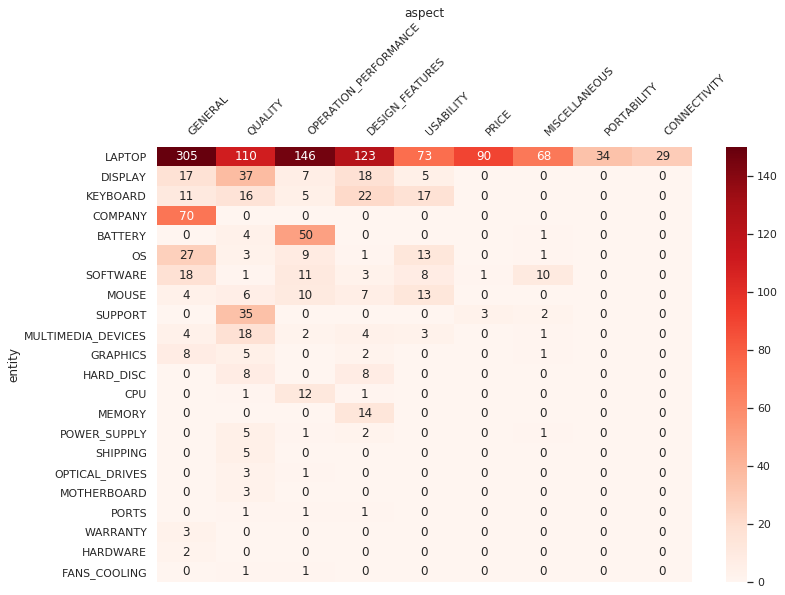

In [13]:
plt.figure(figsize=(12,8))
sns.set(font_scale=1)
heatmap = sns.heatmap(heatmap_df, annot= True, fmt = "d", cmap = "Reds", vmax = 150)
heatmap.xaxis.set_ticks_position('top')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='left')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False)
heatmap.xaxis.set_label_position("top")
plt.show()

## 2 Cross-Lingual Transfer Learning Result and Analysis
In this section, we the performance of the model chosen in tuning in cross-lingual transfer setting.

In [14]:
test_file_en = "../../data/semeval2016/bert-pair/text-level/EN_Laptop_Text_Test_Gold_NLI_M.csv"
test_file_ch = "../../data/semeval2016/bert-pair/text-level/CH_Laptop_Text_Test_Gold_NLI_M.csv"

df_test_en = pd.read_csv(test_file_en, 
                       delimiter = "\t",
                       names = ["sent_id", "label", "entity:aspect", "text"]
                       )
df_test_en["label"] = df_test_en.label.map(map_dict)

df_test_ch = pd.read_csv(test_file_ch, 
                       delimiter = "\t",
                       names = ["sent_id", "label", "entity:aspect", "text"]
                       )
df_test_ch["label"] = df_test_ch.label.map(map_dict)

In [15]:
result_dirs = {
    "./text-level/Test_Baseline/":("Naive-Baseline", df_test_ch),
    "./text-level/XLIN_NLI_M_512_Official_Over_Mix_1/":("English-Only", df_test_en),
    "./text-level/XLIN_NLI_M_512_Official_Over_Mix_1_CH/":("Cross-Lingual", df_test_ch)
}

### 2.1 Calculate the performance numbers in Table 3 in the paper

In [16]:
test_results = rau.combine_labels_preds(result_dirs)
metrics_df = rau.generate_confusion_matrix(test_results)
overall_metrics_df = rau.generate_agg_confusion_matrix(metrics_df)
accuracy_df = rau.cal_sentiment_acc(test_results)

#show the model performance over different training epoch
#we will selet the model from epoch seven for comparison
#since it's the epoch that performs best at the more challenging
#aspect category detection task
accuracy_types = ["4-class", "3-class", "2-class"]
# accuracy_types = ["4-class"]
for acc_type in accuracy_types:
    overall_metrics_df = overall_metrics_df.merge(accuracy_df[accuracy_df.accuracy_type==acc_type], 
                                                  how="inner", 
                                                  on=["model","eval_round"])
#     print(overall_metrics_df.columns)
    overall_metrics_df.columns = list(overall_metrics_df.columns[:-1]) + [acc_type + "_Acc."]                                           
overall_metrics_df[["model","eval_round","precision","recall","f1","4-class_Acc.", "3-class_Acc.", "2-class_Acc."]]

,model,eval_round,precision,recall,f1,4-class_Acc.,3-class_Acc.,2-class_Acc.
0,Cross-Lingual,1,0.814516,0.185662,0.302395,0.647059,0.664151,0.705411
1,Cross-Lingual,2,0.735409,0.347426,0.471910,0.608456,0.654717,0.713427
2,Cross-Lingual,3,0.620499,0.411765,0.495028,0.634191,0.673585,0.765531
3,Cross-Lingual,4,0.611111,0.485294,0.540984,0.656250,0.681132,0.789579
4,Cross-Lingual,5,0.695522,0.428309,0.530148,0.634191,0.649057,0.733467
5,Cross-Lingual,6,0.728223,0.384191,0.503008,0.676471,0.698113,0.761523
6,Cross-Lingual,7,0.715569,0.439338,0.544419,0.694853,0.715094,0.779559
7,Cross-Lingual,8,0.711180,0.420956,0.528868,0.700368,0.718868,0.775551
8,English-Only,1,0.743750,0.218750,0.338068,0.704044,0.722642,0.767535
9,English-Only,2,0.658098,0.470588,0.548767,0.713235,0.762264,0.817635


### 2.2 Draw the aspect category detection metric trend graph (figure 3 in the paper)

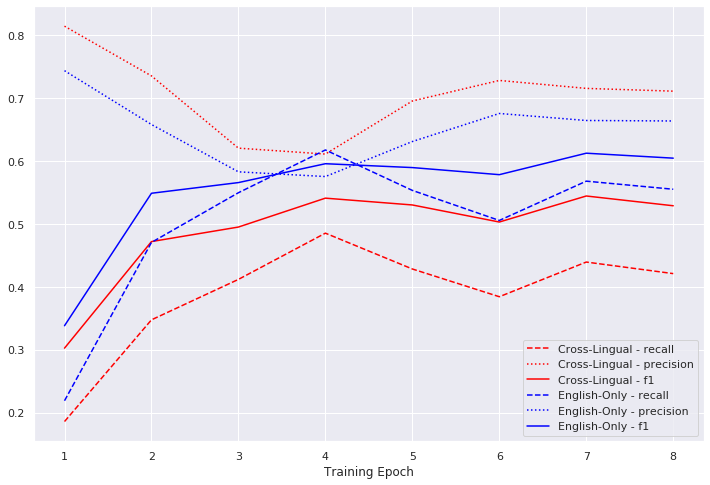

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
color = {
    "English-Only":"blue",
    "Cross-Lingual":"red"}
ls = {"recall":'dashed', "precision":'dotted', "f1":'solid'}
for key, grp in overall_metrics_df.groupby(["model"]):
    if key in color:
        for metric in ["recall", "precision", "f1"]:
            ax = grp.plot(ax=ax, kind='line', x='eval_round', y=metric, 
                          label=key+" - "+metric, linestyle=ls[metric], color = color[key])
plt.xlabel('Training Epoch')
plt.legend(loc='best')
plt.show()

==========================================================================================

### 2.3 Calculate and compare English-Only and Cross-Lingual models accuracy by class

In [18]:
gbo = test_results.groupby(by = ["model", "eval_round"])

In [19]:
acc_df = pd.DataFrame(columns = ["model", "eval_round", "accuracy_type", "sent_id", "entity:aspect", "text", "label", "pred"])


models = []
eval_rounds = []
accuracy_types = []
accuracies = []
filters = [[4], [4,3], [4,3,1]]
col_filters = [[0,1,2,3], [0,1,2], [0,2]]
types = ["4-class", "3-class", "2-class"]
for i in range(len(filters)):
    for key, sub_df in gbo:
        # 4 class accuracy:
        
        sub_df = sub_df.set_index(["sent_id", "entity:aspect", "text"])
#         print(sub_df)
        preds = sub_df.loc[~sub_df.label.isin(filters[i]), ["prob_0", "prob_1", "prob_2", "prob_3"]] \
                      .iloc[:, col_filters[i]] \
                      .idxmax(axis=1) \
                      .str.slice(start=-1) \
                      .astype("int") \
                      .rename("pred")

        labels = sub_df.loc[~sub_df.label.isin(filters[i]), "label"] \
                       .astype("int")
        
        new_df = pd.concat([labels, preds], axis=1)
        new_df = new_df.reset_index()
        new_df.insert(loc = 0, column = "model", value = key[0])
        new_df.insert(loc = 1, column = "eval_round", value = key[1])
        new_df.insert(loc = 2, column = "accuracy_type", value = types[i])
        acc_df = pd.concat([acc_df, new_df], ignore_index=True)

In [20]:
xlin_acc_df = acc_df[(acc_df.model == "Cross-Lingual") & (acc_df.eval_round == 7)]
engl_acc_df = acc_df[(acc_df.model == "English-Only") & (acc_df.eval_round == 7)]

In [21]:
merge_acc_df = xlin_acc_df.merge(engl_acc_df, how = "inner", on = ["accuracy_type", "sent_id", "entity:aspect"], suffixes= ("_Xlin", "_Engl"))

In [22]:
acc_by_label_df = merge_acc_df[["accuracy_type", "sent_id", "label_Xlin", "pred_Xlin", "pred_Engl"]]
english_only_preds = acc_by_label_df.groupby(["accuracy_type","pred_Engl"]).sent_id.count().reset_index()
english_only_preds.columns = ["accuracy_type", "class", "english_pred_count"]
xlin_preds = acc_by_label_df.groupby(["accuracy_type","pred_Xlin"]).sent_id.count().reset_index()
xlin_preds.columns = ["accuracy_type", "class", "xlin_pred_count"]
acc_by_label_df["correct_Xlin"] = (acc_by_label_df.pred_Xlin == acc_by_label_df.label_Xlin).astype("int")
acc_by_label_df["correct_Engl"] = (acc_by_label_df.pred_Engl == acc_by_label_df.label_Xlin).astype("int")
acc_by_label_df = acc_by_label_df.groupby(["accuracy_type", "label_Xlin"]) \
                                 .agg({"sent_id": "count",
                                       "correct_Xlin": "sum", 
                                       "correct_Engl": "sum"})
acc_by_label_df["acc_Xlin"] = acc_by_label_df.correct_Xlin/acc_by_label_df.sent_id
acc_by_label_df["acc_Engl"] = acc_by_label_df.correct_Engl/acc_by_label_df.sent_id
acc_by_label_df = acc_by_label_df.reset_index()

acc_by_label_df = acc_by_label_df[["accuracy_type", "label_Xlin", "acc_Xlin", "acc_Engl"]]
acc_by_label_df.columns = ["accuracy_type", "class", "acc_Xlin", "acc_Engl"]

/home/ehou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ehou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [23]:
acc_by_label_df = acc_by_label_df.merge(english_only_preds, on = ["accuracy_type", "class"])
acc_by_label_df = acc_by_label_df.merge(xlin_preds, on = ["accuracy_type", "class"])
revs_map_dict = {0:'positive', 1:'neutral', 2:'negative', 3:'conflict'}
acc_by_label_df["class"] = acc_by_label_df["class"].map(revs_map_dict)
acc_by_label_df = acc_by_label_df.set_index(["accuracy_type", "class"])
acc_by_label_df = acc_by_label_df[["english_pred_count", "xlin_pred_count", "acc_Engl","acc_Xlin"]]

In [24]:
acc_by_label_df

english_pred_count  xlin_pred_count  acc_Engl  \
accuracy_type class                                                     
2-class       positive                 410              391  0.961424   
              negative                  89              108  0.469136   
3-class       positive                 417              401  0.928783   
              neutral                   28               19  0.064516   
              negative                  85              110  0.438272   
4-class       positive                 422              410  0.919881   
              neutral                   26               21  0.064516   
              negative                  85              111  0.438272   
              conflict                  11                2  0.142857   

                        acc_Xlin  
accuracy_type class               
2-class       positive  0.916914  
              negative  0.493827  
3-class       positive  0.887240  
              neutral   0.064516  
              negative  0.481481  
4-class       positive  0.887240  
              neutral   0.064516  
              negative  0.475309  
              conflict  0.000000

=============================================================================================================

### 2.4 Look at the examples that English-Only baseline gets right but incorrectly predicted by Cross-Lingual

In [25]:
metrics_by_category = metrics_df.reset_index(level = "eval_round") \
                       .fillna(0)
metrics_by_category["total_positive"] = metrics_by_category["true_positive"]+metrics_by_category["false_negative"]
metrics_by_category["total_negative"] = metrics_by_category["true_negative"]+metrics_by_category["false_positive"]

metrics_by_category["precision"] = metrics_by_category["true_positive"]/(metrics_by_category["true_positive"]+metrics_by_category["false_positive"])
metrics_by_category["recall"] = metrics_by_category["true_positive"]/(metrics_by_category["true_positive"]+metrics_by_category["false_negative"])
metrics_by_category["f1"] = 2 * metrics_by_category["precision"] * metrics_by_category["recall"] / (metrics_by_category["precision"] + metrics_by_category["recall"])

Compare English-Only and Cross-Lingual's F1-scores by aspect category and identify if there is any category with significant drop in performance during the learning transferring

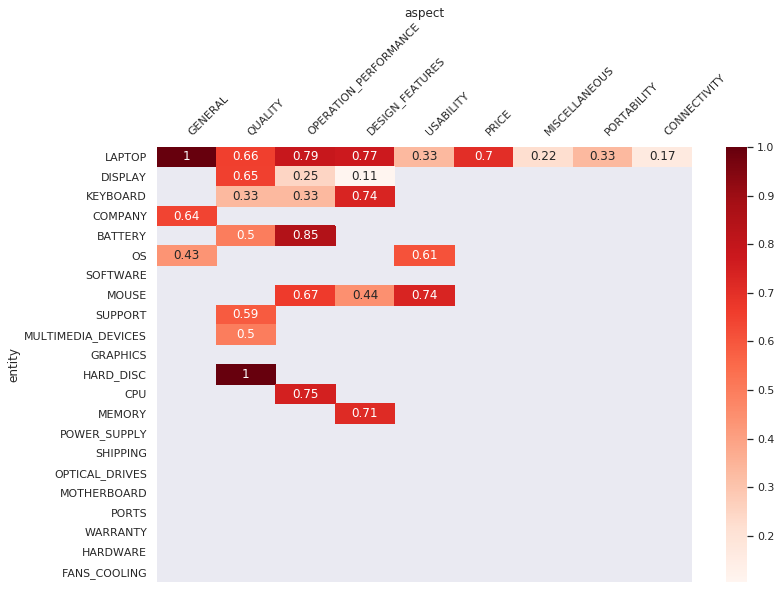

In [26]:
es_df = metrics_by_category.reset_index()["entity:aspect"].str.split("-", expand=True)
es_df.columns = ["entity", "aspect"]
heatmap_df2 = pd.concat([es_df, metrics_by_category.reset_index()], axis=1)
heatmap_df2 = heatmap_df2[(heatmap_df2.model=="English-Only") & (heatmap_df2.eval_round == 7)]
heatmap_df2 = heatmap_df2.set_index(["entity", "aspect"])
heatmap_df2 = heatmap_df2["f1"].unstack()
heatmap_df2 = heatmap_df2.reindex(heatmap_df.sum().sort_values(ascending=False).index, axis = 1)
heatmap_df2 = heatmap_df2.reindex(heatmap_df.sum(axis = 1).sort_values(ascending=False).index, axis = 0)
plt.figure(figsize=(12,8))
sns.set(font_scale=1)
heatmap = sns.heatmap(heatmap_df2, annot= True, fmt = ".2g", cmap = "Reds")
heatmap.xaxis.set_ticks_position('top')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='left')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False)
heatmap.xaxis.set_label_position("top")
plt.show()

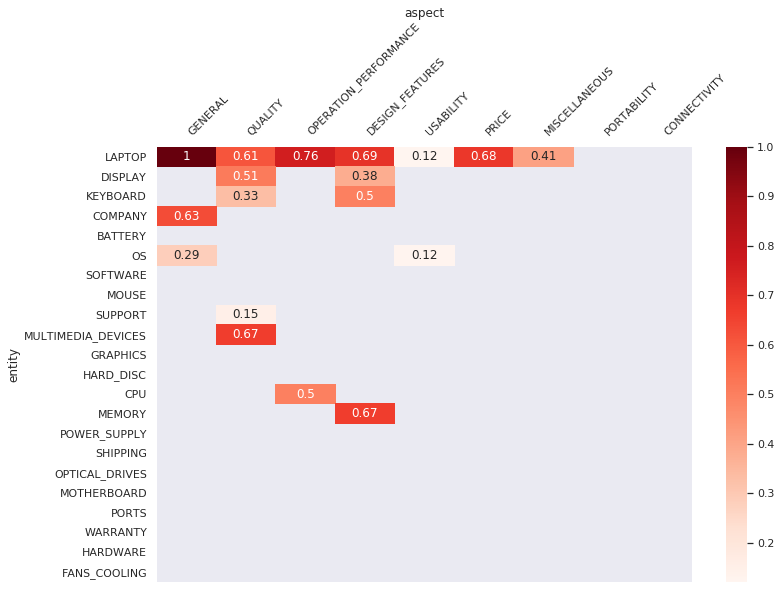

In [27]:
es_df = metrics_by_category.reset_index()["entity:aspect"].str.split("-", expand=True)
es_df.columns = ["entity", "aspect"]
heatmap_df2 = pd.concat([es_df, metrics_by_category.reset_index()], axis=1)
heatmap_df2 = heatmap_df2[(heatmap_df2.model=="Cross-Lingual") & (heatmap_df2.eval_round == 7)]
heatmap_df2 = heatmap_df2.set_index(["entity", "aspect"])
heatmap_df2 = heatmap_df2["f1"].unstack()
heatmap_df2 = heatmap_df2.reindex(heatmap_df.sum().sort_values(ascending=False).index, axis = 1)
heatmap_df2 = heatmap_df2.reindex(heatmap_df.sum(axis = 1).sort_values(ascending=False).index, axis = 0)
plt.figure(figsize=(12,8))
sns.set(font_scale=1)
heatmap = sns.heatmap(heatmap_df2, annot= True, fmt = ".2g", cmap = "Reds")
heatmap.xaxis.set_ticks_position('top')
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, horizontalalignment='left')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False)
heatmap.xaxis.set_label_position("top")
plt.show()

All of BATTERY:OPERATION_PERFORMANCE's categories's F1-score went from 0.85 to 0. Therefore, we look at the examples and try to see if we can spot anything.

In [28]:
eng_only_mask = (test_results.model=="English-Only") & (test_results.eval_round == 7)
xlin_mask = (test_results.model=="Cross-Lingual") & (test_results.eval_round == 7)
xlin_error_analysis = test_results[eng_only_mask]
target_example_mask = (xlin_error_analysis["entity:aspect"] == "BATTERY-OPERATION_PERFORMANCE") & \
                      (xlin_error_analysis.label != 4) & \
                      (xlin_error_analysis.label == xlin_error_analysis.pred)

In [29]:
target_examples = xlin_error_analysis[target_example_mask]
target_examples = test_results[xlin_mask].merge(target_examples, how = "inner", on = ["sent_id", "entity:aspect"], suffixes= ("_Xlin", "_Engl"))

In [30]:
for i in range(len(target_examples)):
    print(target_examples.loc[i,"text_Engl"])
    print(target_examples.loc[i,"text_Xlin"])
    print("="*100)

What a great laptop, I can run my games and work really fast. Really light you can carry with you everywhere. Great battery life. Everything at a very great price. I completely recommend it.
多么出色的笔记本电脑，我可以运行我的游戏并真正快速地工作。真正的轻便，您可以随身携带。电池寿命长。一切都是非常优惠的价格。我完全推荐它。
Great computer. Very great Apple product as expected. Good battery life. Great color on screen. Good speakers from laptop computer. Be aware of price differences when purchasing computer. Price was higher when purchased on MAC when compared to price showing on PC when I bought this product. Amazon has since fixed the price to show the same, but it is now higher on both platforms (but price is the same now).
很棒的电脑。如预期的苹果产品非常出色。电池寿命长。屏幕色彩鲜艳。笔记本电脑的优秀扬声器。购买计算机时请注意价格差异。与在我购买此产品时在PC上显示的价格相比，在MAC上购买时的价格更高。此后，亚马逊已将价格固定为显示相同的价格，但是现在两个平台上的价格都更高（但现在价格相同）。
I wanted a laptop on a budget just for my university teaching needs (making Word Documents, PowerPoints, Excels, PDFs - Office is not included). This laptop is fine for those applications a